In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style('white')
plt.set_cmap('gist_gray')


# We also install a package to read NiFTI files
import nibabel as nib

import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.utils.data as utils
import time
import copy

<Figure size 432x288 with 0 Axes>

In [2]:
import os
from IPython.display import clear_output


skullstripped_img_list = []
ori_img_list = []
seg_img_list = []
file_id = []
sample_size = 0
root_path = "/shared/ixi-dataset/"
for i in range(19):
    dir_name = root_path + "IXI-T1-" + str(i)
    anat_directories = [x for x in os.listdir(dir_name) if x.endswith('.anat')]
    for anat_directory in anat_directories:
        ori_file_name = dir_name + '/' + anat_directory + '/T1_biascorr.nii.gz'
        seg_file_name = dir_name + '/' + anat_directory + "/T1_fast_seg.nii.gz"
        if anat_directory[0:3] == 'IXI' and os.path.exists(ori_file_name) and os.path.exists(seg_file_name):
            ori_img = nib.load(ori_file_name).get_data()
            seg_img = nib.load(seg_file_name).get_data()
            skullstripped_img = ori_img * (seg_img > 0)
            ori_img_list.append(ori_img)
            seg_img_list.append(seg_img)
            skullstripped_img = (skullstripped_img - np.mean(skullstripped_img)) / np.std(skullstripped_img)
            skullstripped_img_list.append(skullstripped_img)
            file_id.append(anat_directory[3:6])
            sample_size += 1
            clear_output(wait=True)
            #print(sample_size)

print(len(skullstripped_img_list))

536


Shape of the MRI : (256, 181, 150)


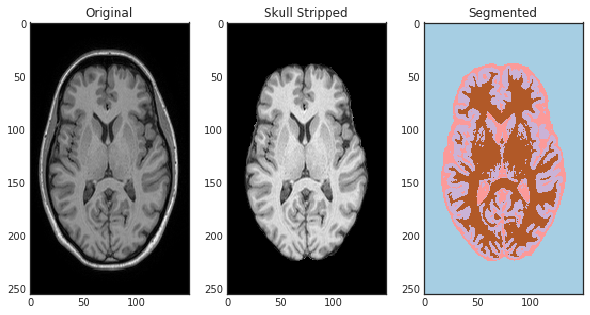

In [3]:
dimension = 1
s = 90
sample = 5

plt.figure(figsize=(10, 5))
print('Shape of the MRI : {}'.format(ori_img_list[sample].shape))
plt.subplot(131)
plt.imshow(np.take(ori_img_list[sample], s, dimension))
plt.title('Original');

plt.subplot(132)
plt.imshow(np.take(skullstripped_img_list[sample], s, dimension))
plt.title('Skull Stripped');

plt.subplot(133)
plt.imshow(np.take(seg_img_list[sample], s, dimension), cmap='Paired')
plt.title('Segmented');

In [5]:
new_img_list = []

for i in range(len(skullstripped_img_list)):  
#     print(i)
    d_0 = skullstripped_img_list[i].shape[0]
    d_1 = skullstripped_img_list[i].shape[1]
    d_2 = skullstripped_img_list[i].shape[2]
    new_img = skullstripped_img_list[i]
    start_0 = int((d_0 - 64) / 2)
    start_1 = int((d_1 - 64) / 2)
    start_2 = int((d_2 - 64) / 2)
    new_img = new_img[start_0:start_0 + 64,start_1:start_1 + 64, start_2:start_2 + 64]
#     else:
#         if d_1 % 2 == 0:
#             pad_width = int((180 - d_1) / 2)
#             new_img = np.pad(np.asarray(new_img),((0,0),(pad_width, pad_width),(0,0)),"constant") 
#         else: 
#             pad_width_0 = int((180 - d_1) / 2)
#             pad_width_1 = pad_width_0 + 1
#             new_img = np.pad(np.asarray(new_img),((0,0),(pad_width_0, pad_width_1),(0,0)),"constant") 

    #modify the dimensions by cropping and zero-padding so that all the images' sizes become 224*224
#     if d_2 > 150:
#         start_2 = int((d_2 - 150) / 2)
#         new_img = new_img[:,:,start_2:start_2 + 150]
#     else:
#         if d_2 % 2 == 0:
#             pad_width = int((150 - d_2) / 2)
#             new_img = np.pad(np.asarray(new_img),((0,0),(0,0),(pad_width, pad_width)),"constant") 
#         else: 
#             pad_width_0 = int((150 - d_2) / 2)
#             pad_width_1 = pad_width_0 + 1
#             new_img = np.pad(np.asarray(new_img),((0,0),(0,0),(pad_width_0, pad_width_1)),"constant") 
#     print(new_img.shape)
    new_img_list.append(new_img)
new_img_list = torch.from_numpy(np.asarray(new_img_list))
print('Shape of the MRI : {}'.format(new_img_list.shape))


Shape of the MRI : torch.Size([536, 256, 10, 150])


In [6]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [7]:
#Saves the tensor
# torch.save(new_img_list,"../../../data/data_preserved.pt")
x = torch.load("../../../data/data_64_3.pt")
x = torch.reshape(x,(536,1,64,64,64))
print(x.shape)

torch.Size([536, 1, 256, 10, 150])


In [8]:
y = torch.load("../../../data/ages.pt")
n = y.shape[0]
print(y.shape)

torch.Size([536])


In [9]:
dataset = utils.TensorDataset(x, y)

In [10]:
train_indices = [i for i in range(n) if (i % 5 == 0 or i % 5 == 2 or i % 5 == 4)]
val_indices = [i for i in range(n) if i % 5 == 1]
test_indices = [i for i in range(n) if i not in train_indices and i not in val_indices]

print("There are %d (%.2f) training data points, %d (%.2f) validation data points,\and %d (%.2f) test data points" %(len(train_indices),len(train_indices)/n,len(val_indices),\
                                                                                                                  len(val_indices)/n,len(test_indices),len(test_indices)/n))
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False,sampler=utils.sampler.SubsetRandomSampler(train_indices))
dataloaders['val'] = torch.utils.data.DataLoader(dataset, batch_size=4,
                                             shuffle=False,sampler=utils.sampler.SubsetRandomSampler(val_indices))

There are 322 (0.60) training data points, 107 (0.20) validation data points,nd 107 (0.20) test data points


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_offset = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_offset = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device,dtype = torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_offset += torch.sum(torch.abs(outputs - labels.data))

            epoch_loss = running_loss / n
            epoch_offset = running_offset / n

            print('{} Loss: {:.4f} Diff: {:.4f}'.format(
                phase, epoch_loss, epoch_offset))

            # deep copy the model
            if phase == 'val' and epoch_offset < best_offset:
                best_offset = epoch_offset
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Diff: {:4f}'.format(best_offset))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [20]:
channel_1 = 64
channel_2 = 32
channel_3 = 16
# model = nn.Sequential(
#     nn.Conv2d(in_channels=256, out_channels=channel_1, kernel_size=5, stride=1, \
#               padding=2, bias=True),
#     nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=5, stride=1, \
#               padding=2, bias=True),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size = 2, stride=2),
#     nn.Conv2d(in_channels=channel_2, out_channels=channel_1, kernel_size=3, stride=1, \
#               padding=1,bias=True),
#     nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, stride=1, \
#               padding=1,bias=True),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size = 2, stride=2),
#     nn.Conv2d(in_channels=channel_2, out_channels=channel_1, kernel_size=3, stride=1, \
#               padding=1,bias=True),
#     nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, stride=1, \
#               padding=1,bias=True),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size = 2, stride=2),
#     Flatten(),
#     nn.Linear(channel_2 * 1 * 18, 1),
# )

model = nn.Sequential(
    nn.Conv3d(1, channel_1, 5, 1, padding=2, bias=True).to(device),
    nn.Conv3d(channel_1, channel_2, 5, 1, padding=2, bias=True).to(device),
    nn.BatchNorm3d(32).to(device),
    nn.ReLU().to(device),
    nn.MaxPool3d(kernel_size = 2, stride=2).to(device),
    nn.Conv3d(channel_2, channel_1,3,1,padding=1,bias=True).to(device),
    nn.Conv3d(channel_1, channel_2,3,1,padding=1,bias=True).to(device),
    nn.BatchNorm3d(32).to(device),
    nn.ReLU().to(device),
    nn.MaxPool3d(kernel_size = 2, stride=2).to(device),
    nn.Conv3d(channel_2, channel_1,3,1,padding=1,bias=True).to(device),
    nn.Conv3d(channel_1, channel_2,3,1,padding=1,bias=True).to(device),
    nn.BatchNorm3d(32).to(device),
    nn.ReLU().to(device),
    nn.MaxPool3d(kernel_size = 2, stride=2).to(device),
    Flatten().to(device),
    nn.Linear(channel_2 * 1 * 32* 18, 1).to(device),
)

In [21]:
# model_ft = models.resnet18(pretrained=True)

# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 1)

# model_ft = model_ft.to(device)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 223.0070 Diff: 38.6194
val Loss: 51.0467 Diff: 10.8295

Epoch 1/9
----------
train Loss: 175.8667 Diff: 35.3155
val Loss: 46.0958 Diff: 10.2910

Epoch 2/9
----------
train Loss: 176.5734 Diff: 34.0299
val Loss: 45.5299 Diff: 10.2228

Epoch 3/9
----------
train Loss: 167.9996 Diff: 34.9039
val Loss: 44.9112 Diff: 10.1738

Epoch 4/9
----------
train Loss: 170.2944 Diff: 34.6489
val Loss: 62.8028 Diff: 11.5857

Epoch 5/9
----------
train Loss: 187.5040 Diff: 35.7039
val Loss: 94.4626 Diff: 14.0423

Epoch 6/9
----------
train Loss: 171.7242 Diff: 35.6727
val Loss: 45.9240 Diff: 10.3728

Epoch 7/9
----------
train Loss: 163.8908 Diff: 34.4193
val Loss: 46.0241 Diff: 10.3595

Epoch 8/9
----------
train Loss: 165.9047 Diff: 34.8254
val Loss: 45.0034 Diff: 10.2758

Epoch 9/9
----------
train Loss: 161.8025 Diff: 34.2890
val Loss: 45.5565 Diff: 10.2795

Training complete in 59m 48s
Best val Diff: 10.173769


In [23]:
def check_error(data,labels,model):
    print('Checking error on test set')   
    total_abs_err = 0.0
    num_samples = data.shape[0]
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        data = data.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        labels = labels.to(device=device,dtype=dtype)
        scores = model(data)
        print((labels - scores).shape)
        total_abs_err += torch.abs(labels - scores).sum()
        mean_abs_err = float(total_abs_err) / num_samples
        print('Got error %.4f' % (mean_abs_err))

In [25]:
check_error(x[val_indices,:], y[val_indices],model)

Checking error on test set


RuntimeError: CUDA out of memory. Tried to allocate 9.80 GiB (GPU 0; 11.17 GiB total capacity; 1.96 GiB already allocated; 1.42 GiB free; 73.89 MiB cached)